<a href="https://colab.research.google.com/github/komazawa-deep-learning/komazawa-deep-learning.github.io/blob/master/2021notebooks/2021_1022The_Annotated_%22Attention_is_All_You_Need%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# トランスフォーマー注釈

- [オリジナルブログ The Annotated Transformer](http://nlp.seas.harvard.edu/2018/04/03/attention.html)
- [オリジナル Colab ソース](https://drive.google.com/file/d/1xQXSv6mtAOLXxEMi8RvaW8TW-7bvYBDF/view)
- このファイル <https://drive.google.com/open?id=1naZHpTLgfLd54RcY4yi0WyQYoKf1yBBo>


<center>
<img src="http://nlp.seas.harvard.edu/images/the-annotated-transformer_0_0.png" width="66%">
</center>

私は教える際，機械学習の最近の動向を理解する方法として，実装を重視しています。
この投稿は， この目標に沿って自分を誠実に保つための試みです。
NIPS 2017 で発表された最近の [Attention is All You Need](https://arxiv.org/abs/1706.03762) 論文は， 機械翻訳や 潜在的に自然言語処理 全般の新しい手法として， 瞬く間にインパクトのある論文となりました。
この論文は非常にわかりやすく書かれていますが， これまでの常識では， 正しく実装するのはかなり難しいとされてきました。

> この投稿では， 論文の最初から最後までを追い， 各構成要素をコードで実装してみました。
(元の論文から若干の順序変更やスキップをしています)。
この文書自体が作業用のノートであり， 完全に使用可能で効率的な実装であるべきです。
[PyTorch](http://pytorch.org/) と [torchtext](https://github.com/pytorch/text) をインストールする必要があります。
完全なコードは [github](https://github.com/harvardnlp/annotated-transformer) にあります。
> - Alexander "Sasha" Rush ([@harvardnlp](https://twitter.com/harvardnlp))


In [ ]:
!pip install --upgrade pytorch torchtext numpy matplotlib spacy 

In [ ]:
# Standard PyTorch imports
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy
from torch.autograd import Variable

# For plots
%matplotlib inline
import matplotlib.pyplot as plt


# 1. 背景

Extended Neural GPU [16], ByteNet [18],  ConvS2S [9] などのモデルでは， 基本的な構成要素として畳み込みニューラルネットワークが用いられており， すべての入出力位置について隠れた表現を並列に計算しています。
これらのモデルでは， 任意の 2 つの入出力位置からの信号を関連付けるために必要な演算の数は， 位置間の距離に応じて ConvS2S では線形に， ByteNet では対数に増加します。
このため， 離れた位置間の依存関係を学習することが難しくなります [12]。
トランスフォーマーでは， 注目度の高い位置を平均化することで実効的な解像度が低下しますが， これは 3.2 節で説明する 多頭注意機構によって相殺され， 一定の演算数に抑えられます。

自己注意 (イントラ注意と呼ばれることもある) は 1 つの配列の異なる位置を関連づけて， その配列の表現を計算するための注意機構です。
自己注意は， 読解，抽象的な要約，テキストの含意，課題に依存しない文の表現の学習など，さまざまな課題で利用されています [4, 27, 28, 22]。
エンド2エンドの メモリネットワークは， 配列に沿った再帰ではなく， 再帰的な注意機構に基づいており， 簡易な言語の質問応答や言語モデルの課題で優れた性能を発揮することが示されています [34]。

しかし，私たちの知る限り，トランスフォーマーは， 配列を揃えた RNN や畳み込みを使用せずに， 自己注意に完全に依存して入力と出力の表現を計算する初めての伝達モデルです。
以下の節では， トランスフォーマーについて説明し， 自己注意の動機付けを行い [17, 18] や[9] などのモデルと比較して，その利点を議論します。


# 2. モデル構成

ほとんどの競合するニューラルネットワーク伝達モデルは， 符号化器-復号化器構造を持っています[(cite)](cho2014learning,bahdanau2014neural,sutskever14)。
ここで，符号化器は， 入力された記号表現の列 $(x_1, ..., x_n)$ を連続表現の列 $mathbf{z} = (z_1, ..., z_n)$ にマッピングします。
復号化器は $mathbf{z}$ が与えられると，1 要素ずつ記号の出力系列 $(y_1,...,y_m)$ を生成します。
各ステップにおいて， モデルは自己回帰的に [(cite)](graves2013generating) 次の記号を生成する際に， 前に生成された記号を追加入力として消費します。

In [ ]:
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base model for this and many 
    other models.
    """
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator
        
    def forward(self, src, tgt, src_mask, tgt_mask):
        "Take in and process masked src and target sequences."
        memory = self.encoder(self.src_embed(src), src_mask)
        output = self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)
        return output

トランスフォーマーは， この全体的なアーキテクチャに沿って， 図 1 の左半分と右半分にそれぞれ示されているように， 符号化器と復号化器の両方に， 積み重ねられた自己注意と点ごとの完全連結層を使用しています。

<center>
<img src="http://nlp.seas.harvard.edu/images/the-annotated-transformer_14_0.png" width="33%"><br/>
</center>

## 2.1 符号化器と復号化器の積み重ね



### 2.1.1 符号化器: 

符号化器は $N=6$ 枚の同じ層の積み重ねで構成されています。

In [ ]:
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [ ]:
class Encoder(nn.Module):
    "Core encoder is a stack of N layers"
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, mask):
        "Pass the input (and mask) through each layer in turn."
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

2 つの下位層それぞれの周りに残差接続 [(cite)](he2016deep) を採用し， 続いて層正規化 [(cite)](layernorm2016) を行います。 

In [ ]:
class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

つまり，各下位層の出力は  $\mathrm{LayerNorm}(x + \mathrm{Sublayer}(x))$ となり， $\mathrm{Sublayer}(x)$ は下位層自身が実装する関数です。
 各下位層の出力に ドロップアウト  [(cite)](srivastava2014dropout) を適用してから， 下位層の入力に加えて正規化します。 

これらの残差接続を容易にするために， モデル内のすべての下位層と埋め込み層は，次元$d_{text{model}}=512$ の出力を生成します。

In [ ]:
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity we apply the norm first as opposed to last.
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer function that maintains the same size."
        return x + self.dropout(sublayer(self.norm(x)))

各層には 2 つの下位層があります。
1 つ目は多頭自己注意機構で， 2 つ目は単純な位置ごとの完全連結フィードフォワードネットワークです。

In [ ]:
class EncoderLayer(nn.Module):
    "Encoder is made up of two sublayers, self-attn and feed forward (defined below)"
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        "Follow Figure 1 (left) for connections."
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

### 2.1.2 復号化器:

また，復号化器は $N=6$ 個の同一の階層の積み重ねで構成されています。 


In [ ]:
class Decoder(nn.Module):
    "Generic N layer decoder with masking."
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

各符号化器層の 2 つの下位層に加えて， 復号化器は 3 つ目の下位層を挿入し， 符号化器の積層の出力に対して多頭注意を行います。
符号化器と同様， 各下位層の周りに残差接続を採用し， その後，層正規化を行います。 

In [ ]:
class DecoderLayer(nn.Module):
    "Decoder is made up of three sublayers, self-attn, src-attn, and feed forward (defined below)"
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
 
    def forward(self, x, memory, src_mask, tgt_mask):
        "Follow Figure 1 (right) for connections."
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)

また， 復号化器積層の自己注意下位層を変更し， 位置が後続の位置に注目しないようにしました。 
このマスキングと， 出力埋め込みが 1 位置分の離されていることを組み合わせることで，位置 $i$ の予測は，$i$ よりも小さい位置での既知の出力にのみ依存することができます。

In [ ]:
def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

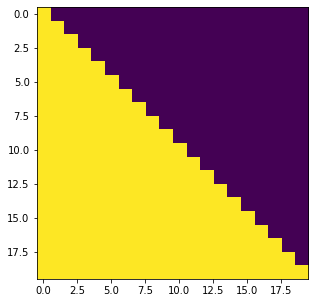

In [ ]:
# 注意のマスクは，各目標単語 (行) が見ることを許される位置 (列) を示す。
# 単語は訓練中に将来の単語を注目するためにブロックされる。
plt.figure(figsize=(5,5))
plt.imshow(subsequent_mask(20)[0])

### 2.1. 3注意: 

注意関数は， クエリとキーと値の対のセットを出力にマッピングするもので， クエリ， キー，バリュー， 出力はすべてベクトルです。
出力は，バリューの加重和として計算され， 各バリューに割り当てられた重みは， クエリと対応するキーの互換性関数によって計算されます。

我々は， この特別な注意を「規格化した内積注意」と呼びます。
入力は，$d_k$ 次元のクエリとキー，$d_v$ 次元のバリューからなっています。
クエリとすべてのキーの内積を計算し， それぞれを $sqrt{d_k}$ で割り， ソフトマックス関数を適用して値の重みを求めます。

<center>
<img width="220px" src="http://nlp.seas.harvard.edu/images/the-annotated-transformer_33_0.png">
</center>

実際には， 行列 $Q$ にまとめられた一連のクエリに対して同時に注意関数を計算します。  キーとバリューも行列 $K$ と $V$ にまとめられます。
出力の行列を次のように計算します。                     
                                                                 
$$
\mathrm{Attention}\left(Q, K, V\right) = \mathrm{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
$$

In [ ]:
def attention(query, key, value, mask=None, dropout=0.0):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) \
             / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    # (Dropout described below)
    p_attn = F.dropout(p_attn, p=dropout)
    return torch.matmul(p_attn, value), p_attn

最も一般的に使用される 2 つの注意関数は， Bahdanau の加算型注意[(cite)](bahdanau2014neural)と，Luong の 内積型 (乗算型) 注意です。
内積型注意は，$frac{1}{\sqrt{d_k}}$ という規格化因子を除いて， 我々のアルゴリズムと同じです。
加算型注意は，隠れ層が 1 つのフィードフォワードネットワークを使って互換性関数を計算します。
この 2 つは理論的な複雑さは似ていますが， 内積型注意は， 高度に最適化された行列乗算コードを用いて実装できるため， 実際にはより高速で， よりスペース効率の高いものとなっています。

$d_k$ の小さな値では 2 つの機構は同じような性能を発揮しますが，$d_k$ が大きな値では規格化なしで加算的注意が内積注意を上回ります [(引用)](DBLP:journals/corr/BritzGLL17)。
$d_k$ の値が大きくなると， 内積の大きさが大きくなり， ソフトマックス関数の勾配が極端に小さくなる領域に押し込まれるのではないかと考えています (内積が大きくなる理由を説明するために， $q$ と $k$ の成分が平均 $0$,  分散 $1$ の独立した確率変数であると仮定します。
そうすると， それらの内積である $q \cdot k = \sum_{i=1}^{d_k} q_ik_i$ は 平均 $0$,  分散 $d_k$ となります)。
この効果を打ち消すために， 内積を $\frac{1}{\sqrt{d_k}}$ で規格化します。

### 2.1.4 多頭注意

$d_{\text{model}}$ 次元のキー，バリュー， クエリで単一の注意関数を実行する代わりに， クエリ， キー， バリューをそれぞれ $d_k$ 次元,  $d_k$ 次元, $d_v$ 次元に異なる，学習した線形射影で $h$ 回投影することが有益であることがわかりました。

これらの射影されたバージョンのクエリ，キー， バリューのそれぞれに対して， 注意関数を並行して実行し， $d_v$ 次元の出力値を得ます。
これらは連結され， 再び射影され，最終的な値が得られます。

<center>
<img width="33%" src="http://nlp.seas.harvard.edu/images/the-annotated-transformer_38_0.png"><br/>
</center>

多頭注意では， モデルは異なる位置にある異なる表現下位空間からの情報を共同で注目することができます。
単一注意では， 平均化がこれを阻害します。

$$    
\mathrm{MultiHead}(Q, K, V) = \mathrm{Concat}(\mathrm{head_1}, ..., \mathrm{head_h})W^O
$$

ここで，$\mathrm{head_i} = \mathrm{Attention}(QW^Q_i, KW^K_i, VW^V_i)$

ここで，射影されるのは，パラメータ行列 $W^Q_i \in \mathbb{R}^{d_{\text{model}} \times d_k}$, $W^K_i \in \mathbb{R}^{d_{\text{model}} \times d_k}$, $W^V_i \in \mathbb{R}^{d_{\text{model}} \times d_v}$ と$W^O \in \mathbb{R}^{hd_v \times d_{\text{model}}}$ です。

ここでは，$h=8$ 個の並列注意層 (ヘッド) を採用しています。
それぞれのヘッドには $d_k=d_v=d_{\text{model}}/h=64$ を使用します。
各ヘッドの次元が小さくなったことで， 全体の計算コストは， 全次元の単一注意の場合と同様になります。

In [ ]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.p = dropout
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        
    def forward(self, query, key, value, mask=None):
        "Implements Figure 2"
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        
        # 1) すべての線形投影を一括して行う d_model => h x d_k
        query, key, value = [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
                             for l, x in zip(self.linears, (query, key, value))]
        
        # 2) バッチ内のすべての投影されたベクトルに注意をかけます。
        x, self.attn = attention(query, key, value, mask=mask, dropout=self.p)
        
        # 3) view  を使って “連結 concat” し 最終的に線形変換を適用する。 
        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

### 2.1.5 本モデルにおける注意の応用

トランスフォーマーは， 多頭注意を 3 つの方法で使用しています。

1. 「エンコーダ・デコーダ注意」層では，クエリは前のデコーダ層から来て， メモリのキーとバリューはエンコーダの出力から来ます。
これにより， デコーダのすべての位置が， 入力系列のすべての位置に注目することができます。
これは [(cite)](wu2016google, bahdanau2014neural, JonasFaceNet2017) などのsequence-to-sequence モデルにおける典型的な符号化器-復号化器間の注意機構を模倣しています。   

2. 符号化器には自己注意層がある。
自己注意層では， すべてのキー， バリュー， およびクエリが同じ場所 (この場合は符号化器の前の層の出力) から来る。
符号化器の各位置は， 符号化器の前の層のすべての位置に注目することができます。

3. 同様に，復号化器内の自己注意層は， 復号化器内の各位置が，その位置までの符号化器内のすべての位置に言及することを可能にします。
自己回帰性を維持するためには， 復号化器内での左向きの情報の流れを防ぐ必要があります。
ソフトマックスの入力に含まれる， 不正な接続に対応するすべての値をマスク化排除 ($-infty$ に設定) することで， スケーリングされた内積型注意の内部にこれを実装します。

## 2.2 位置ごとのフィードフォワードネットワーク

注意下位層に加えて， 符号化器と復号化器の各層には， 完全結合のフィード・フォワード・ネットワークが含まれており，これは各位置に個別かつ同一に適用されます。
このネットワークは， ReLU 活性化を挟んだ 2 つの線形変換で構成されています。

$$
\mathrm{FFN}(x)=\max(0, xW_1 + b_1) W_2 + b_2
$$                                                                                      

線形変換は， 異なる位置では同じですが，層ごとに異なるパラメータを使用します。
これを別の表現で表すと， カーネルサイズ 1 の 2 つの畳み込みとなります。
入出力の次元は $d_{\text{model}}=512$ であり，内部層の次元は $d_{ff}=2048$ です。

In [ ]:
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        # Torch linears have a `b` by default. 
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

## 2.3 埋め込みとソフトマックス

他の系列変換モデルと同様に，学習済み埋め込み層を用いて，入力トークンと出力トークンを次元 $d_{text{model}}$ のベクトルに変換します。
また，復号化器の出力を次のトークンの予測確率に変換するために， 通常の学習した線形変換とソフトマックス関数を使用します。
我々のモデルでは [(cite)](press2016using) と同様に，2 つの埋め込み層と事前ソフトマックス線形変換の間で同じ重み行列を共有しています。
埋め込み層では， その重みに $\sqrt{d_{text{model}}}$ を掛けています。

In [ ]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

## 2.4 位置の符号化

我々のモデルには再帰も畳み込みもないので， モデルが系列の順序を利用するためには， 系列内のトークンの相対的または絶対的な位置に関する何らかの情報を注入する必要があります。
そのために， 符号化器と復号化器の積層の底部にある入力埋め込みに「位置符号化」を追加します。
位置符号化は埋め込みと同じ次元 $d_{\text{model}}$ を持ち， 2 つの埋め込みの和が取れるようになっています。
位置符号化には学習型と固定型の多くの選択肢があります [(cite)](JonasFaceNet2017)。

ここでは，異なる周波数の正弦波(サイン)と 余弦波 (コサイン) 関数を使用しています。

$$
PE_{(pos,2i)} = \sin(pos / 10000^{2i/d_{\text{model}}})\\
PE_{(pos,2i+1)} = \cos(pos / 10000^{2i/d_{\text{model}}})
$$

ここで、$pos$ は位置, $i$ は次元を表します。
つまり， 位置情報の各次元は， 正弦波に対応しています。
波長は， $2\pi$ から $10000\cdot 2\pi$ へと幾何学的に変化していきます。
この関数を選んだのは， 任意の固定ズレ $k$ に対して $PE_{pos+k}$ は $PE_{pos}$ の一次関数として表現できるため， モデルが相対的な位置による注意を容易に学習できるのではないかと考えたからです。

さらに， 符号化積層と復号化積層の両方で， 埋め込みと位置符号化の合計にドロップアウトを適用します。
ベースモデルでは $P_{drop}=0.1$ の割合を使用しています。

In [ ]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], requires_grad=False)
        return self.dropout(x)

In [ ]:
# The positional encoding will add in a sine wave based on position.
# The frequency and offset of the wave is different for each dimension.
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20, 0)
y = pe.forward(Variable(torch.zeros(1, 100, 20)))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])
None

また，学習した位置符号化 [(cite)](JonasFaceNet2017) を代わりに使う実験も行いましたが，2 つのバージョンはほぼ同じ結果を得ることができました。
正弦波バージョンを選択したのは， 学習時に遭遇したものよりも長い系列長にモデルを外挿することができるかもしれないからです。

## 2.5 生成

In [ ]:
class Generator(nn.Module):
    "Standard generation step. (Not described in the paper.)"
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

## 2.6 完全モデル

In [ ]:
def make_model(src_vocab, tgt_vocab, N=6, d_model=512, d_ff=2048, h=8, dropout=0.1):
    "Construct a model object based on hyperparameters."
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model, dropout)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab))
    
    # This was important from their code. Initialize parameters with Glorot or fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform(p)
    return model

In [ ]:
# Small example model.
tmp_model = make_model(10, 10, 2)
tmp_model

# 3. 訓練

この節では，我々のモデルの訓練体制について説明します。


## 3.1 学習データとバッチ処理

約 450 万の文対からなる標準的な WMT 2014 英独データセットで学習を行いました。
文は バイトペアエンコーディング cite{DBLP:journals/corr/BritzGLL17} を用いて符号化されており，約 37000 トークンのソース-ターゲット語彙が共有されています。
英仏語については，3600 万文からなるかなり大規模な WMT2014 英仏語データセットを使用し，トークンを 32000 語ピースの語彙に分割しました [(cite)](wu2016google)。

文の対は，おおよその配列の長さごとにまとめられました。
各学習バッチには，約 25000 個のソーストークンと約 25000 個のターゲットトークンを含む文対のセットが含まれています。

## 3.2 ハードウェアとスケジュール

8 台の NVIDIA P100 GPU を搭載した 1 台のマシンでモデルの学習を行いました。
本稿で紹介したハイパーパラメータを用いた基本モデルでは，各訓練ステップに約 0.4 秒かかりました。
ベースモデルの学習には，合計 100,000 ステップ，12 時間を要しました。
ビッグモデルの場合，ステップタイムは 1.0 秒でした。
大規模モデルは 300,000 ステップ (3.5 日) の訓練を行いました。

## 3.3 最適化

Adam 最適化 [(cite)](kingma2014adam)を使用し  $\beta_1=0.9$, $\beta_2=0.98$, $\epsilon=10^{-9}$ としました。
学習の過程で学習率を式にしたがって変化させました。

$$
lrate = d_{\text{model}}^{-0.5} \cdot \min({step\_num}^{-0.5},
{step\_num} \cdot {warmup\_steps}^{-1.5})
$$

これは、最初の $warmup\_steps$ の学習ステップでは学習率を線形に増加させ， その後はステップ数の逆平方根に比例して学習率を減少させることに相当します。
ここでは $warmup\_steps=4000$ としました。

In [ ]:
# Note: This part is incredibly important. 
# Need to train with this setup of the model is very unstable.
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup**(-1.5)))
        
def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

In [ ]:
# Three settings of the lrate hyperparameters.
opts = [NoamOpt(512, 1, 4000, None), 
        NoamOpt(512, 1, 8000, None),
        NoamOpt(256, 1, 4000, None)]
plt.plot(np.arange(1, 20000), [[opt.rate(i) for opt in opts] for i in range(1, 20000)])
plt.legend(["512:4000", "512:8000", "256:4000"])
None

## 3.4 正則化



### 3.4.1 ラベル平滑化

学習時には，$\epsilon_{ls}=0.1$ [(cite)](DBLP:journals/corr/SzegedyVISW15)という値のラベル平滑化を採用しました。
これは， モデルがより不確かになるように学習するため，パープレキシティ (錯乱度) を悪化させますが，精度と BLEU スコアを向上させます。

In [ ]:
class LabelSmoothing(nn.Module):
    "Implement label smoothing."
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(size_average=False)
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad=False))

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


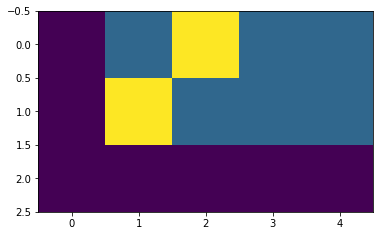

In [ ]:
#Example
crit = LabelSmoothing(5, 0, 0.5)
predict = torch.FloatTensor([[0, 0.2, 0.7, 0.1, 0],
                             [0, 0.2, 0.7, 0.1, 0], 
                             [0, 0.2, 0.7, 0.1, 0]])
v = crit(Variable(predict.log()), 
         Variable(torch.LongTensor([2, 1, 0])))

# Show the target distributions expected by the system.
plt.imshow(crit.true_dist)
None

In [ ]:
# 与えられた選択肢に非常に自信を持った場合
# ラベル平滑化はモデルにペナルティを与え始める 
crit = LabelSmoothing(5, 0, 0.2)
def loss(x):
    d = x + 3 * 1
    predict = torch.FloatTensor([[0, x / d, 1 / d, 1 / d, 1 / d],
                                 ])
    print(predict.log())
    return crit(Variable(predict.log()),
                 Variable(torch.LongTensor([1]))).item() 

plt.plot(np.arange(1, 100), [loss(x) for x in range(1, 100)])

NameError: ignored

### 3.4.2 メモリ最適化

In [ ]:
def loss_backprop(generator, criterion, out, targets, normalize):
    """
    Memory optmization. Compute each timestep separately and sum grads.
    """
    assert out.size(1) == targets.size(1)
    total = 0.0
    out_grad = []
    for i in range(out.size(1)):
        out_column = Variable(out[:, i].data, requires_grad=True)
        gen = generator(out_column)
        loss = criterion(gen, targets[:, i]) / normalize
        total += loss.item()
        #total += loss.data[0]
        loss.backward()
        out_grad.append(out_column.grad.data.clone())
    out_grad = torch.stack(out_grad, dim=1)
    out.backward(gradient=out_grad)
    return total

In [ ]:
def make_std_mask(src, tgt, pad):
    src_mask = (src != pad).unsqueeze(-2)
    tgt_mask = (tgt != pad).unsqueeze(-2)
    tgt_mask = tgt_mask & Variable(subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
    return src_mask, tgt_mask

In [ ]:
def train_epoch(train_iter, model, criterion, opt, transpose=False):
    model.train()
    for i, batch in enumerate(train_iter):
        src, trg, src_mask, trg_mask = \
            batch.src, batch.trg, batch.src_mask, batch.trg_mask
        out = model.forward(src, trg[:, :-1], src_mask, trg_mask[:, :-1, :-1])
        loss = loss_backprop(model.generator, criterion, out, trg[:, 1:], batch.ntokens) 
                        
        model_opt.step()
        model_opt.optimizer.zero_grad()
        if i % 10 == 1:
            print(i, loss, model_opt._rate)

In [ ]:
def valid_epoch(valid_iter, model, criterion, transpose=False):
    model.test()
    total = 0
    for batch in valid_iter:
        src, trg, src_mask, trg_mask = \
            batch.src, batch.trg, batch.src_mask, batch.trg_mask
        out = model.forward(src, trg[:, :-1], src_mask, trg_mask[:, :-1, :-1])
        loss = loss_backprop(model.generator, criterion, out, trg[:, 1:], batch.ntokens) 
        

In [ ]:
class Batch:
    def __init__(self, src, trg, src_mask, trg_mask, ntokens):
        self.src = src
        self.trg = trg
        self.src_mask = src_mask
        self.trg_mask = trg_mask
        self.ntokens = ntokens
    
def data_gen(V, batch, nbatches):
    for i in range(nbatches):
        data = torch.from_numpy(np.random.randint(1, V, size=(batch, 10)))
        src = Variable(data, requires_grad=False)
        tgt = Variable(data, requires_grad=False)
        src_mask, tgt_mask = make_std_mask(src, tgt, 0)
        yield Batch(src, tgt, src_mask, tgt_mask, (tgt[1:] != 0).data.sum())

In [ ]:
V = 11
criterion = LabelSmoothing(size=V, padding_idx=0, smoothing=0.0)
model = make_model(V, V, N=2)
model_opt = get_std_opt(model)
for epoch in range(2):
    train_epoch(data_gen(V, 30, 20), model, criterion, model_opt)

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


1 2.80071884393692 6.987712429686844e-07
11 2.69090473651886 4.192627457812107e-06
1 2.500949651002884 7.686483672655528e-06
11 2.2902756482362747 1.118033988749895e-05


# 4. 実際例

In [ ]:
# For data loading.
from torchtext import data, datasets

In [ ]:
!pip install torchtext spacy
!python -m spacy download en
!python -m spacy download de

In [ ]:
# Load words from IWSLT

#!pip install torchtext spacy
#!python -m spacy download en
#!python -m spacy download de

import spacy
spacy_de = spacy.load('de')
spacy_en = spacy.load('en')

import torchtext

def tokenize_de(text):
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]

BOS_WORD = '<s>'
EOS_WORD = '</s>'
BLANK_WORD = "<blank>"
#SRC = data.Field(tokenize=tokenize_de, pad_token=BLANK_WORD)
SRC = torchtext.legacy.data.field(tokenize=tokenize_de, 
                                  lower=True, 
                                  pad_token=BLANK_WORD,
                                  init_token=BOS_WORD, 
                                  eos_token=EOS_WORD)
TGT = data.Field(tokenize=tokenize_en, init_token = BOS_WORD, 
                 eos_token = EOS_WORD, pad_token=BLANK_WORD)

MAX_LEN = 100
train, val, test = datasets.IWSLT.splits(exts=('.de', '.en'), fields=(SRC, TGT), 
                                         filter_pred=lambda x: len(vars(x)['src']) <= MAX_LEN and 
                                         len(vars(x)['trg']) <= MAX_LEN)
MIN_FREQ = 1
SRC.build_vocab(train.src, min_freq=MIN_FREQ)
TGT.build_vocab(train.trg, min_freq=MIN_FREQ)

In [ ]:
# Detail. Batching seems to matter quite a bit. 
# This is temporary code for dynamic batching based on number of tokens.
# This code should all go away once things get merged in this library.

BATCH_SIZE = 4096
global max_src_in_batch, max_tgt_in_batch
def batch_size_fn(new, count, sofar):
    "Keep augmenting batch and calculate total number of tokens + padding."
    global max_src_in_batch, max_tgt_in_batch
    if count == 1:
        max_src_in_batch = 0
        max_tgt_in_batch = 0
    max_src_in_batch = max(max_src_in_batch,  len(new.src))
    max_tgt_in_batch = max(max_tgt_in_batch,  len(new.trg) + 2)
    src_elements = count * max_src_in_batch
    tgt_elements = count * max_tgt_in_batch
    return max(src_elements, tgt_elements)

class MyIterator(data.Iterator):
    def create_batches(self):
        if self.train:
            def pool(d, random_shuffler):
                for p in data.batch(d, self.batch_size * 100):
                    p_batch = data.batch(
                        sorted(p, key=self.sort_key),
                        self.batch_size, self.batch_size_fn)
                    for b in random_shuffler(list(p_batch)):
                        yield b
            self.batches = pool(self.data(), self.random_shuffler)
            
        else:
            self.batches = []
            for b in data.batch(self.data(), self.batch_size,
                                          self.batch_size_fn):
                self.batches.append(sorted(b, key=self.sort_key))

def rebatch(pad_idx, batch):
    "Fix order in torchtext to match ours"
    src, trg = batch.src.transpose(0, 1), batch.trg.transpose(0, 1)
    src_mask, trg_mask = make_std_mask(src, trg, pad_idx)
    return Batch(src, trg, src_mask, trg_mask, (trg[1:] != pad_idx).data.sum())

train_iter = MyIterator(train, batch_size=BATCH_SIZE, device=0,
                        repeat=False, sort_key=lambda x: (len(x.src), len(x.trg)),
                        batch_size_fn=batch_size_fn, train=True)
valid_iter = MyIterator(val, batch_size=BATCH_SIZE, device=0,
                        repeat=False, sort_key=lambda x: (len(x.src), len(x.trg)),
                        batch_size_fn=batch_size_fn, train=False)

In [ ]:
# Create the model an load it onto our GPU.
pad_idx = TGT.vocab.stoi["<blank>"]
model = make_model(len(SRC.vocab), len(TGT.vocab), N=6)
model_opt = get_std_opt(model)
model.cuda()

In [ ]:

criterion = LabelSmoothing(size=len(TGT.vocab), padding_idx=pad_idx, smoothing=0.1)
criterion.cuda()
for epoch in range(15):
    train_epoch((rebatch(pad_idx, b) for b in train_iter), model, criterion, model_opt)
    valid_epoch((rebatch(pad_idx, b) for b in valid_iter), model, criterion)


OTHER

In [ ]:
BOS_WORD = '<s>'
EOS_WORD = '</s>'
BLANK_WORD = "<blank>"
SRC = data.Field()
TGT = data.Field(init_token = BOS_WORD, eos_token = EOS_WORD, pad_token=BLANK_WORD) # only target needs BOS/EOS

MAX_LEN = 100
train = datasets.TranslationDataset(path="/n/home00/srush/Data/baseline-1M_train.tok.shuf", 
                                    exts=('.en', '.fr'),
                                    fields=(SRC, TGT), 
                                    filter_pred=lambda x: len(vars(x)['src']) <= MAX_LEN and 
                                         len(vars(x)['trg']) <= MAX_LEN)
SRC.build_vocab(train.src, max_size=50000)
TGT.build_vocab(train.trg, max_size=50000)

In [ ]:
pad_idx = TGT.vocab.stoi["<blank>"]
print(pad_idx)
model = make_model(len(SRC.vocab), len(TGT.vocab), pad_idx, N=6)
model_opt = get_opt(model)
model.cuda()

In [ ]:
criterion = LabelSmoothing(size=len(TGT.vocab), padding_idx=pad_idx, label_smoothing=0.1)
criterion.cuda()
for epoch in range(15):
    train_epoch(train_iter, model, criterion, model_opt)
    valid_epoch()

In [ ]:
print(pad_idx)
print(len(SRC.vocab))

1
50002


In [ ]:
torch.save(model, "/n/rush_lab/trans_ipython.pt")

In [ ]:
#weight = torch.ones(len(TGT.vocab))
#weight[pad_idx] = 0
#criterion = nn.NLLLoss(size_average=False, weight=weight.cuda())
criterion = LabelSmoothing(size=len(TGT.vocab), padding_idx=pad_idx, label_smoothing=0.1)
criterion.cuda()
for epoch in range(15):
    train_epoch(train_iter, model, criterion, model_opt)

In [ ]:
1 10.825187489390373 6.987712429686844e-07
101 9.447168171405792 3.56373333914029e-05
201 7.142856806516647 7.057589553983712e-05
301 6.237934365868568 0.00010551445768827134
401 5.762486848048866 0.00014045301983670557
501 5.415792358107865 0.00017539158198513977
601 5.081815680023283 0.000210330144133574
701 4.788327748770826 0.00024526870628200823
801 4.381739928154275 0.0002802072684304424
901 4.55433791608084 0.00031514583057887664
1001 4.911875109748507 0.0003500843927273108
1101 4.0579032292589545 0.0003850229548757451
1201 4.2276234351193125 0.0004199615170241793
1301 3.932735869428143 0.00045490007917261356
1401 3.8179439397063106 0.0004898386413210477
1501 3.3608515430241823 0.000524777203469482
1601 3.832796103321016 0.0005597157656179162
1701 2.907085266895592 0.0005946543277663504
1801 3.5280659823838505 0.0006295928899147847
1901 2.895841649500653 0.0006645314520632189
2001 3.273784235585481 0.000699470014211653
2101 3.181488689899197 0.0007344085763600873
2201 3.4151616653980454 0.0007693471385085215
2301 3.4343731447588652 0.0008042857006569557
2401 3.0505455391539726 0.0008392242628053899
2501 2.8089329147478566 0.0008741628249538242
2601 2.7827929875456903 0.0009091013871022583
2701 2.4428516102489084 0.0009440399492506926
2801 2.4015486147254705 0.0009789785113991267
2901 2.3568112018401735 0.001013917073547561
3001 2.6349758653668687 0.0010488556356959952
3101 2.5981983028614195 0.0010837941978444295
3201 2.666826274838968 0.0011187327599928637
3301 3.0092043554177508 0.0011536713221412978
3401 2.4580375660589198 0.0011886098842897321
3501 2.586465588421561 0.0012235484464381662
3601 2.5663993963389657 0.0012584870085866006
3701 2.9430236657499336 0.0012934255707350347
3801 2.464644919440616 0.001328364132883469
3901 2.7124062888276512 0.0013633026950319032
4001 2.646443709731102 0.0013971932312809247
4101 2.7294750874862075 0.001380057517579748
4201 2.1295202329056337 0.0013635372009002666
4301 2.596563663915731 0.001347596306985731
4401 2.1265982036820787 0.0013322017384983986
4501 2.3880532500334084 0.0013173229858148
4601 2.6129120760888327 0.0013029318725783852
4701 2.2873719420749694 0.001289002331178292
4801 2.4949760700110346 0.0012755102040816328
4901 2.496607314562425 0.001262433067573089
5001 2.1889712483389303 0.0012497500749750088
5101 1.8677761815488338 0.0012374418168536253
5201 2.2992054556962103 0.0012254901960784316
5301 2.664361578106707 0.0012138783159049418
5401 2.705850490485318 0.0012025903795063202
5501 2.581445264921058 0.0011916115995949978
5601 2.2480602325085783 0.0011809281169581616
5701 1.9289666265249252 0.0011705269268863989
5801 2.4863578918157145 0.0011603958126073107
5901 2.632946971571073 0.0011505232849492607
6001 2.496141305891797 0.0011408985275576757
6101 2.6422974687084206 0.0011315113470699342
6201 2.448802186456305 0.0011223521277270118